In [19]:
import phylovelo as pv
import pandas as pd
import matplotlib.pyplot as plt

Load simulated lineage infomation

In [ ]:
# tree_file = '../datas/line_model/tree_origin_var0.02_rvg0.05.csv0'

Reconstruct lineage tree

In [ ]:
# reconstruct('../datas/line_model/'+tree_file, output='../datas/line_model/'+tree_file+'.nwk', num=1000, is_balance=True)

Load reconstructed tree and cell information

In [11]:
tree_file = '../../datas/line_model/tree_origin_var0.02_rvg0.05.csv0.nwk'
phylo_tree, branch_colors = pv.ana_utils.loadtree(tree_file)
sampled_cells = [i.name for i in phylo_tree.get_terminals()]
cell_names, cell_states, cell_generation = pv.sim_utils.get_annotation('../../datas/line_model/tree_origin_var0.02_rvg0.05.csv0')
cell_states = pd.DataFrame(data=cell_states, index=cell_names).loc[sampled_cells]
cell_generation = pd.DataFrame(data=cell_generation, index=cell_names).loc[sampled_cells].to_numpy()

In [12]:
sd = pv.data_struct.scData(phylo_tree=phylo_tree, 
                            cell_states=cell_states.to_numpy().T[0].astype('int'), 
                            cell_generation=cell_generation.T[0].astype('int'),
                            cell_names=sampled_cells)

Simulate single cell base expression matrix

In [15]:
ge, base_expr = pv.sim_utils.sim_base_expr(sd.phylo_tree, 
                                             cell_states,
                                             Ngene=2000, 
                                             r_variant_gene=0.4, 
                                             diff_map={0:[0],1:[0],2:[1],3:[2],4:[3]},
                                             forward_map={},
                                             mu0_loc=0, 
                                             mu0_scale=1, 
                                             drift_loc=0, 
                                             drift_scale=0.3,
                                            )

/home/wangkun/miniconda3/lib/python3.9/site-packages/phylovelo/sim_utils.py:149: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  base_expr[cell.name] = ge.expr(


Add lineage noise and drawn count from base expression

In [16]:
sd.count = pv.sim_utils.get_count_from_base_expr(pv.sim_utils.add_lineage_noise(sd.phylo_tree, base_expr), alpha=0.1)

tSNE embedding and visualization

In [21]:
sd.dimensionality_reduction(methor='tsne', scale=1, n_highly_variable_genes=0, perplexity=30, target='count')

/home/wangkun/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/wangkun/miniconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


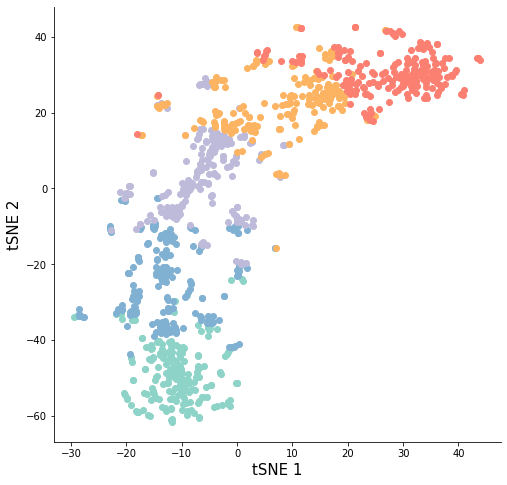

In [22]:
fig, ax = plt.subplots(figsize=(8,8))
cmps = ['#8dd3c7','#80b1d3','#bebada','#fdb462','#fb8072']
for i in range(5):
    ax.scatter(sd.Xdr.iloc[sd.cell_states==i, 0], sd.Xdr.iloc[sd.cell_states==i, 1], c=cmps[i])
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

Normalize data and filter genes with low expression

In [23]:
sd.normalize_filter(is_normalize=False, is_log=False, min_count=10, target_sum=None)

Phylogenetic velocity inference and project velocity into embedding. For simulation data, we use ZINB model to analyze

In [25]:
sd = pv.inference.velocity_inference(sd, sd.cell_generation, cutoff=0.9, target='count', exact=True)
sd = pv.embedding.velocity_embedding(sd, target='count')

/home/wangkun/miniconda3/lib/python3.9/site-packages/phylovelo/inference.py:29: RuntimeWarning: invalid value encountered in double_scalars
  pmf0 = -n_zeros * np.log((1 - psi) + psi * (n / (n + mu)) ** n)
/home/wangkun/miniconda3/lib/python3.9/site-packages/phylovelo/inference.py:333: RuntimeWarning: invalid value encountered in log
  y = np.log(y + 1)


Show results

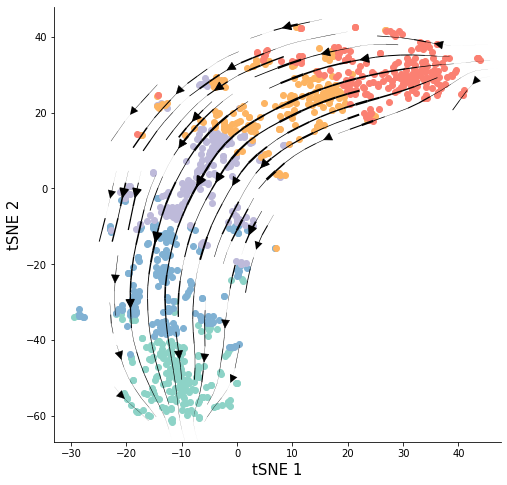

In [28]:
fig, ax = plt.subplots()
cmps = ['#8dd3c7','#80b1d3','#bebada','#fdb462','#fb8072']
for i in range(5):
    ax.scatter(sd.Xdr.iloc[sd.cell_states==i, 0], sd.Xdr.iloc[sd.cell_states==i, 1], c=cmps[i])
ax = pv.ana_utils.velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'stream',streamdensity=1.2, grid_density=25, radius=3, lw_coef=400, arrowsize=2)
ax.figure.set_size_inches(8,8)
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)